In [8]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras


In [9]:
import tensorflow as tf
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K
from keras.layers import Conv2D, Lambda, MaxPooling2D, BatchNormalization, concatenate, GlobalAveragePooling2D, Dense
from keras.models import Model
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt 
import time

In [10]:
from keras.preprocessing.image import ImageDataGenerator
train_dataset = ImageDataGenerator(rescale=1./255)
test_dataset = ImageDataGenerator(rescale=1./255)
validation_dataset = ImageDataGenerator(rescale=1./255)

batchsize = 10
train_generator=train_dataset.flow_from_directory('lagupdated_512x512/train/', 
                                                  target_size=(224, 224), 
                                                  batch_size=batchsize, 
                                                  class_mode='categorical')
 
validation_generator = validation_dataset.flow_from_directory('lagupdated_512x512/val',
        target_size=(224, 224),
        batch_size=batchsize,
        class_mode='categorical',
        shuffle=False)
test_generator = test_dataset.flow_from_directory('lagupdated_512x512/test/',
       target_size=(224, 224),
       batch_size=batchsize,
       class_mode='categorical',
       shuffle=False)

Found 3420 images belonging to 2 classes.
Found 972 images belonging to 2 classes.
Found 472 images belonging to 2 classes.


# Model Creation
VGG Net: VGG network has simplest structure with 3 x 3 filter in each convolutional layer. There are two variant available VGG-16 and VGG1-9. In the image above VGG network is presneted.
Transfer Learning: The VGGNet pre-trained on ImageNet and Inception module for transfer learning, and trained the newly formed neural networks using new datasets. The approach combines the advantages of the VGGNet and Inception module.

In [11]:
#DENSENET121
base_model1=keras.applications.DenseNet121(
    include_top=True, weights="imagenet", input_tensor=None, 
    input_shape=None, pooling=None,classes=1000,
    #classifier_activation='softmax'
)

#DenseNet169
base_model2=keras.applications.DenseNet169(
    include_top=True, weights="imagenet", input_tensor=None, 
    input_shape=None, pooling=None,classes=1000,
    #classifier_activation='softmax'
)


#VGG19
base_model3=keras.applications.vgg19.VGG19(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation='softmax'
)

#MobileNet
base_model4=tf.keras.applications.MobileNetV2(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation='softmax'
)

#ResNet50 
base_model5 = tf.keras.applications.resnet50.ResNet50(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation='softmax')

#Inception V3
base_model6=tf.keras.applications.InceptionV3(
    include_top=True, weights="imagenet", input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation="softmax",
)




## setting all layers as non-trainable

In [12]:
for layer in base_model1.layers:
    layer.trainable=False
for layer in base_model2.layers:
    layer.trainable=False
for layer in base_model3.layers:
    layer.trainable=False
for layer in base_model4.layers:
    layer.trainable=False
for layer in base_model5.layers:
    layer.trainable=False
for layer in base_model6.layers:
    layer.trainable=False

## Defining custom activation function
As per the paper, custom activation function Swish is used in place of Relu in the model.

In [13]:
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K
def swish(x):
    return (K.sigmoid(x) * x)
get_custom_objects().update({'swish': Activation(swish)})

## Defining convolution batch normalization function with Swish activation

In [14]:
def Conv2d_BN(x, nb_filter,kernel_size, padding='same',strides=(1,1)):   
    x = Conv2D(nb_filter,kernel_size,padding=padding,strides=strides)(x)
    x = Lambda(swish)(x)
    x = BatchNormalization(axis=3)(x)  
    return x

## Defining Inception Block:
Inception Modules are used in Convolutional Neural Networks to allow for more efficient computation and deeper Networks through a dimensionality reduction with stacked 1×1 convolutions. The modules were designed to solve the problem of computational expense, as well as overfitting, among other issues.

In [15]:
def Inception(x,nb_filter):  
    branch1x1 = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1))  
  
    branch3x3 = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1))  
    branch3x3 = Conv2d_BN(branch3x3,nb_filter,(3,3), padding='same',strides=(1,1))  
  
    branch5x5 = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1))  
    branch5x5 = Conv2d_BN(branch5x5,nb_filter,(3,3), padding='same',strides=(1,1))
    branch5x5 = Conv2d_BN(branch5x5,nb_filter,(3,3), padding='same',strides=(1,1))
  
    branchpool = MaxPooling2D(pool_size=(3,3),strides=(1,1),padding='same')(x)  
    branchpool = Conv2d_BN(branchpool,nb_filter,(1,1),padding='same',strides=(1,1))  
  
    x = concatenate([branch1x1,branch3x3,branch5x5,branchpool],axis=3)    
    return x

## Adding new layers in model architechture
Global Average Pooling
Fully connected layers are replaced by a global pooling layer to conduct the dimension reduction of feature maps.

In [16]:
#DenseNet121
x = base_model1.layers[-6].output


x = Conv2d_BN(x,512,(3,3),strides=(1,1),padding='same')  
x = MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same')(x) 

x = Inception(x,512)  
x = Inception(x,512)  

x = GlobalAveragePooling2D()(x)
predictions_1 = Dense(2, activation='softmax')(x)
model1 = Model(inputs=base_model1.input, outputs=predictions_1)

In [17]:
#DenseNet169
x = base_model2.layers[-6].output


x = Conv2d_BN(x,512,(3,3),strides=(1,1),padding='same')  
x = MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same')(x) 

x = Inception(x,512)  
x = Inception(x,512)  

x = GlobalAveragePooling2D()(x)
predictions_2 = Dense(2, activation='softmax')(x)
model2 = Model(inputs=base_model2.input, outputs=predictions_2)

In [18]:
#VGG-19
x = base_model3.layers[-6].output


x = Conv2d_BN(x,512,(3,3),strides=(1,1),padding='same')  
x = MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same')(x) 

x = Inception(x,512)  
x = Inception(x,512)  

x = GlobalAveragePooling2D()(x)
predictions_3 = Dense(2, activation='softmax')(x)
model3 = Model(inputs=base_model3.input, outputs=predictions_3)

In [19]:
#MobileNet V2
x = base_model4.layers[-6].output


x = Conv2d_BN(x,512,(3,3),strides=(1,1),padding='same')  
x = MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same')(x) 

x = Inception(x,512)  
x = Inception(x,512)  

x = GlobalAveragePooling2D()(x)
predictions_4 = Dense(2, activation='softmax')(x)
model4 = Model(inputs=base_model4.input, outputs=predictions_4)

In [20]:
#ResNet 50
x = base_model5.layers[-6].output


x = Conv2d_BN(x,512,(3,3),strides=(1,1),padding='same')  
x = MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same')(x) 

x = Inception(x,512)  
x = Inception(x,512)  

x = GlobalAveragePooling2D()(x)
predictions_5 = Dense(2, activation='softmax')(x)
model5 = Model(inputs=base_model5.input, outputs=predictions_5)

In [21]:
#Inception V3
x = base_model6.layers[-6].output


x = Conv2d_BN(x,512,(3,3),strides=(1,1),padding='same')  
x = MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same')(x) 

x = Inception(x,512)  
x = Inception(x,512)  

x = GlobalAveragePooling2D()(x)
predictions_6 = Dense(2, activation='softmax')(x)
model6 = Model(inputs=base_model6.input, outputs=predictions_6)

In [22]:

model1.summary()
model2.summary()
model3.summary()
model4.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 56, 56, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 56, 56, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv3_block2_0_relu (Activatio  (None, 28, 28, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 28, 28, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 28, 28, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 28, 28, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization) 

 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 28, 28, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 28, 28, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 28, 28, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_blo

 conv4_block2_concat (Concatena  (None, 14, 14, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 14, 14, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 14, 14, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 128)  40960       ['conv4_block3_0_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 14, 14, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 14, 14, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block11_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 14, 14, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 14, 14, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 14, 14, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 14, 14, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 14, 14, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block16_1_conv[0][0]']   
 lization)

 conv4_block20_1_conv (Conv2D)  (None, 14, 14, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 14, 14, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 14, 14, 1024  4096        ['conv4_block24_concat[0][0]']   
                                )                                                                 
                                                                                                  
 pool4_relu (Activation)        (None, 14, 14, 1024  0           ['pool4_bn[0][0]']               
          

                                                                                                  
 conv5_block4_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv5_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block4_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block4_1_relu[0][0]']    
                                                                                                  
 conv5_block4_concat (Concatena  (None, 7, 7, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_block5_0_bn (BatchNormal  (None, 7, 7, 640)   2560        ['conv5_block4_concat[0][0]']    
 ization) 

 te)                                                              'conv5_block8_2_conv[0][0]']    
                                                                                                  
 conv5_block9_0_bn (BatchNormal  (None, 7, 7, 768)   3072        ['conv5_block8_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_0_relu (Activatio  (None, 7, 7, 768)   0           ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 7, 7, 128)    98304       ['conv5_block9_0_relu[0][0]']    
                                                                                                  
 conv5_blo

                                                                                                  
 conv5_block13_1_conv (Conv2D)  (None, 7, 7, 128)    114688      ['conv5_block13_0_relu[0][0]']   
                                                                                                  
 conv5_block13_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block13_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block13_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block13_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block13_1_relu[0][0]']   
          

                                                                                                  
 conv2d_96 (Conv2D)             (None, 7, 7, 512)    262656      ['max_pooling2d_4[0][0]']        
                                                                                                  
 conv2d_99 (Conv2D)             (None, 7, 7, 512)    2359808     ['batch_normalization_98[0][0]'] 
                                                                                                  
 lambda_2 (Lambda)              (None, 7, 7, 512)    0           ['conv2d_96[0][0]']              
                                                                                                  
 lambda_5 (Lambda)              (None, 7, 7, 512)    0           ['conv2d_99[0][0]']              
                                                                                                  
 batch_normalization_96 (BatchN  (None, 7, 7, 512)   2048        ['lambda_2[0][0]']               
 ormalizat

 lambda_10 (Lambda)             (None, 7, 7, 512)    0           ['conv2d_104[0][0]']             
                                                                                                  
 lambda_13 (Lambda)             (None, 7, 7, 512)    0           ['conv2d_107[0][0]']             
                                                                                                  
 lambda_14 (Lambda)             (None, 7, 7, 512)    0           ['conv2d_108[0][0]']             
                                                                                                  
 batch_normalization_102 (Batch  (None, 7, 7, 512)   2048        ['lambda_8[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_104 (Batch  (None, 7, 7, 512)   2048        ['lambda_10[0][0]']              
 Normaliza

 ization)                                                                                         
                                                                                                  
 conv2_block2_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block2_2_conv (Conv2D)   (None, 56, 56, 32)   36864       ['conv2_block2_1_relu[0][0]']    
                                                                                                  
 conv2_block2_concat (Concatena  (None, 56, 56, 128)  0          ['conv2_block1_concat[0][0]',    
 te)                                                              'conv2_block2_2_conv[0][0]']    
                                                                                                  
 conv2_blo

 conv2_block6_concat (Concatena  (None, 56, 56, 256)  0          ['conv2_block5_concat[0][0]',    
 te)                                                              'conv2_block6_2_conv[0][0]']    
                                                                                                  
 pool2_bn (BatchNormalization)  (None, 56, 56, 256)  1024        ['conv2_block6_concat[0][0]']    
                                                                                                  
 pool2_relu (Activation)        (None, 56, 56, 256)  0           ['pool2_bn[0][0]']               
                                                                                                  
 pool2_conv (Conv2D)            (None, 56, 56, 128)  32768       ['pool2_relu[0][0]']             
                                                                                                  
 pool2_pool (AveragePooling2D)  (None, 28, 28, 128)  0           ['pool2_conv[0][0]']             
          

                                                                                                  
 conv3_block4_concat (Concatena  (None, 28, 28, 256)  0          ['conv3_block3_concat[0][0]',    
 te)                                                              'conv3_block4_2_conv[0][0]']    
                                                                                                  
 conv3_block5_0_bn (BatchNormal  (None, 28, 28, 256)  1024       ['conv3_block4_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block5_0_relu (Activatio  (None, 28, 28, 256)  0          ['conv3_block5_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_blo

 conv3_block9_0_relu (Activatio  (None, 28, 28, 384)  0          ['conv3_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block9_1_conv (Conv2D)   (None, 28, 28, 128)  49152       ['conv3_block9_0_relu[0][0]']    
                                                                                                  
 conv3_block9_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block9_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block9_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block9_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv4_block1_0_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_1_conv (Conv2D)   (None, 14, 14, 128)  32768       ['conv4_block1_0_relu[0][0]']    
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 14, 14, 128)  512        ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block1_1_bn[0][0]']      
 n)       

 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 32)   36864       ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_block5_concat (Concatena  (None, 14, 14, 416)  0          ['conv4_block4_concat[0][0]',    
 te)                                                              'conv4_block5_2_conv[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block9_concat (Concatena  (None, 14, 14, 544)  0          ['conv4_block8_concat[0][0]',    
 te)                                                              'conv4_block9_2_conv[0][0]']    
                                                                                                  
 conv4_block10_0_bn (BatchNorma  (None, 14, 14, 544)  2176       ['conv4_block9_concat[0][0]']    
 lization)                                                                                        
                                                                                                  
 conv4_block10_0_relu (Activati  (None, 14, 14, 544)  0          ['conv4_block10_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block10_1_conv (Conv2D)  (None, 14, 14, 128)  69632       ['conv4_block10_0_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv4_block14_1_conv (Conv2D)  (None, 14, 14, 128)  86016       ['conv4_block14_0_relu[0][0]']   
                                                                                                  
 conv4_block14_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block14_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block14_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block14_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 conv4_block18_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block18_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block18_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block18_1_relu[0][0]']   
                                                                                                  
 conv4_block18_concat (Concaten  (None, 14, 14, 832)  0          ['conv4_block17_concat[0][0]',   
 ate)                                                             'conv4_block18_2_conv[0][0]']   
                                                                                                  
 conv4_block19_0_bn (BatchNorma  (None, 14, 14, 832)  3328       ['conv4_block18_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block23_0_bn (BatchNorma  (None, 14, 14, 960)  3840       ['conv4_block22_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block23_0_relu (Activati  (None, 14, 14, 960)  0          ['conv4_block23_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block23_1_conv (Conv2D)  (None, 14, 14, 128)  122880      ['conv4_block23_0_relu[0][0]']   
                                                                                                  
 conv4_block23_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block23_1_conv[0][0]']   
 lization)

 conv4_block27_1_conv (Conv2D)  (None, 14, 14, 128)  139264      ['conv4_block27_0_relu[0][0]']   
                                                                                                  
 conv4_block27_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block27_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block27_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block27_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block27_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block27_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block31_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block31_1_relu[0][0]']   
                                                                                                  
 conv4_block31_concat (Concaten  (None, 14, 14, 1248  0          ['conv4_block30_concat[0][0]',   
 ate)                           )                                 'conv4_block31_2_conv[0][0]']   
                                                                                                  
 conv4_block32_0_bn (BatchNorma  (None, 14, 14, 1248  4992       ['conv4_block31_concat[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block32_0_relu (Activati  (None, 14, 14, 1248  0          ['conv4_block32_0_bn[0][0]']     
 on)      

                                                                                                  
 conv5_block3_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv5_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block3_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block3_1_relu[0][0]']    
                                                                                                  
 conv5_block3_concat (Concatena  (None, 7, 7, 736)   0           ['conv5_block2_concat[0][0]',    
 te)                                                              'conv5_block3_2_conv[0][0]']    
                                                                                                  
 conv5_block4_0_bn (BatchNormal  (None, 7, 7, 736)   2944        ['conv5_block3_concat[0][0]']    
 ization) 

 te)                                                              'conv5_block7_2_conv[0][0]']    
                                                                                                  
 conv5_block8_0_bn (BatchNormal  (None, 7, 7, 864)   3456        ['conv5_block7_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block8_0_relu (Activatio  (None, 7, 7, 864)   0           ['conv5_block8_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block8_1_conv (Conv2D)   (None, 7, 7, 128)    110592      ['conv5_block8_0_relu[0][0]']    
                                                                                                  
 conv5_blo

                                                                                                  
 conv5_block12_1_conv (Conv2D)  (None, 7, 7, 128)    126976      ['conv5_block12_0_relu[0][0]']   
                                                                                                  
 conv5_block12_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block12_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block12_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block12_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block12_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block12_1_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv5_block16_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block16_1_relu[0][0]']   
                                                                                                  
 conv5_block16_concat (Concaten  (None, 7, 7, 1152)  0           ['conv5_block15_concat[0][0]',   
 ate)                                                             'conv5_block16_2_conv[0][0]']   
                                                                                                  
 conv5_block17_0_bn (BatchNorma  (None, 7, 7, 1152)  4608        ['conv5_block16_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_blo

 conv5_block21_0_bn (BatchNorma  (None, 7, 7, 1280)  5120        ['conv5_block20_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block21_0_relu (Activati  (None, 7, 7, 1280)  0           ['conv5_block21_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block21_1_conv (Conv2D)  (None, 7, 7, 128)    163840      ['conv5_block21_0_relu[0][0]']   
                                                                                                  
 conv5_block21_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block21_1_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv5_block25_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block25_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block25_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block25_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block25_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block25_1_relu[0][0]']   
                                                                                                  
 conv5_block25_concat (Concaten  (None, 7, 7, 1440)  0           ['conv5_block24_concat[0][0]',   
 ate)     

 conv5_block29_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block29_1_relu[0][0]']   
                                                                                                  
 conv5_block29_concat (Concaten  (None, 7, 7, 1568)  0           ['conv5_block28_concat[0][0]',   
 ate)                                                             'conv5_block29_2_conv[0][0]']   
                                                                                                  
 conv5_block30_0_bn (BatchNorma  (None, 7, 7, 1568)  6272        ['conv5_block29_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block30_0_relu (Activati  (None, 7, 7, 1568)  0           ['conv5_block30_0_bn[0][0]']     
 on)                                                                                              
          

 batch_normalization_111 (Batch  (None, 7, 7, 512)   2048        ['lambda_17[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_114 (Batch  (None, 7, 7, 512)   2048        ['lambda_20[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 7, 7, 512)   0           ['max_pooling2d_7[0][0]']        
                                                                                                  
 conv2d_110 (Conv2D)            (None, 7, 7, 512)    262656      ['max_pooling2d_7[0][0]']        
                                                                                                  
 conv2d_11

 batch_normalization_119 (Batch  (None, 7, 7, 512)   2048        ['lambda_25[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_122 (Batch  (None, 7, 7, 512)   2048        ['lambda_28[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_123 (Batch  (None, 7, 7, 512)   2048        ['lambda_29[0][0]']              
 Normalization)                                                                                   


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Compiling the Model 

In [23]:
def comp():
    learning_rate=0.0001
    decay=1e-6
    momentum=0.8
    nesterov=True
    sgd_optimizer= SGD(lr = learning_rate, decay = decay, momentum = momentum, nesterov = nesterov)
    models=['DenseNet169','DenseNet121','VGG-19','MobileNet','ResNet50','Inception']
    
    for i in models:
        if i=='DenseNet121':
            model1.compile(loss='categorical_crossentropy',optimizer=sgd_optimizer,metrics=['accuracy','mse'])
        elif i=='DenseNet169':
            model2.compile(loss='categorical_crossentropy',optimizer=sgd_optimizer,metrics=['accuracy','mse'])
        if i=='VGG-19':
            model3.compile(loss='categorical_crossentropy',optimizer=sgd_optimizer,metrics=['accuracy','mse'])
        if i=='MobileNet':
            model4.compile(loss='categorical_crossentropy',optimizer=sgd_optimizer,metrics=['accuracy','mse'])
        if i=='ResNet50':
            model5.compile(loss='categorical_crossentropy',optimizer=sgd_optimizer,metrics=['accuracy','mse'])
        else:
            model6.compile(loss='categorical_crossentropy',optimizer=sgd_optimizer,metrics=['accuracy','mse'])

        
if __name__ == "__main__":
    comp()

D:\Anaconda\envs\tf-gpu\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# Training the Models

### 1.DenseNet-121

In [17]:
#DenseNet121
import time
epochs =50
batch_size = 10

start = time.time()
history_1 = model1.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=epochs, batch_size =batch_size,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
end = time.time()
print("Execution Time : ", (end - start))

Epoch 1/50
342/342 [==============================] - 86s 219ms/step - loss: 0.5210 - accuracy: 0.7421 - mse: 0.1730 - val_loss: 0.7745 - val_accuracy: 0.6420 - val_mse: 0.2708
Epoch 2/50
342/342 [==============================] - 71s 206ms/step - loss: 0.4413 - accuracy: 0.8041 - mse: 0.1410 - val_loss: 0.4556 - val_accuracy: 0.7572 - val_mse: 0.1515
Epoch 3/50
342/342 [==============================] - 71s 206ms/step - loss: 0.3978 - accuracy: 0.8284 - mse: 0.1243 - val_loss: 0.4036 - val_accuracy: 0.8107 - val_mse: 0.1276
Epoch 4/50
342/342 [==============================] - 71s 206ms/step - loss: 0.3585 - accuracy: 0.8500 - mse: 0.1109 - val_loss: 0.3589 - val_accuracy: 0.8477 - val_mse: 0.1121
Epoch 5/50
342/342 [==============================] - 71s 206ms/step - loss: 0.3429 - accuracy: 0.8576 - mse: 0.1049 - val_loss: 0.3569 - val_accuracy: 0.8508 - val_mse: 0.1111
Epoch 6/50
342/342 [==============================] - 71s 206ms/step - loss: 0.3224 - accuracy: 0.8687 - mse: 0.097

In [18]:
model1.save('SavedModels/LAG updated/D121.h5')

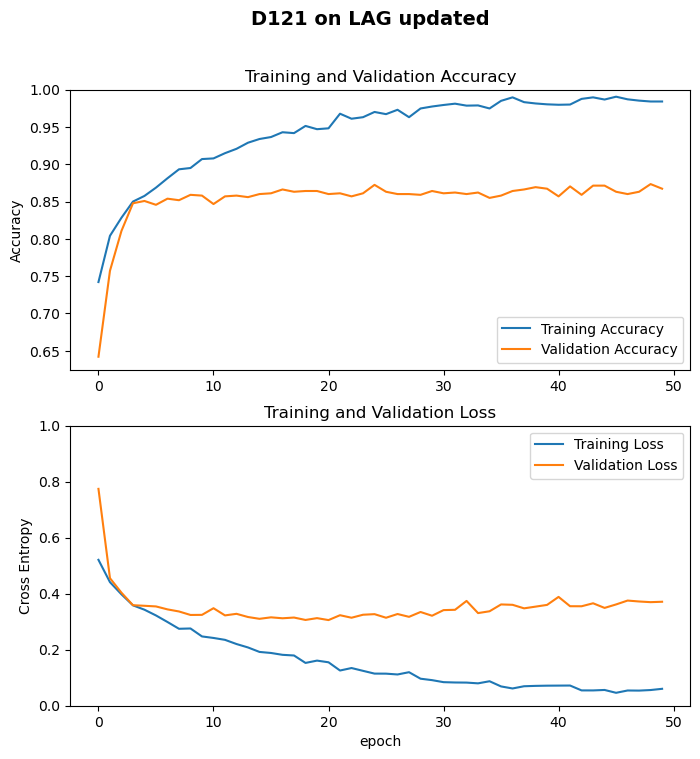

In [19]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']

loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.suptitle('D121 on LAG updated', fontsize=14, fontweight='bold')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [20]:
start=time.time()
test_output_1= model1.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
end=time.time()
print(model1.metrics_names)
print(test_output_1)
print("testing time : "+ str(end-start))

47/47 [==============================] - 5s 111ms/step - loss: 0.4226 - accuracy: 0.8538 - mse: 0.1123
['loss', 'accuracy', 'mse']
[0.42258116602897644, 0.8538135886192322, 0.1122846007347107]
testing time : 5.385902166366577


In [21]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


#Y_pred = model1.predict_generator(validation_generator, 171 // batch_size+1)
Y_pred=model1.predict(test_generator,test_generator.samples//batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

conf=confusion_matrix(test_generator.classes, y_pred)
print(conf)
print('Classification Report')
target_names = ['Gluacoma', 'Normal']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

48/48 [==============================] - 7s 110ms/step
[[131  30]
 [ 39 272]]
Classification Report
              precision    recall  f1-score   support

    Gluacoma       0.77      0.81      0.79       161
      Normal       0.90      0.87      0.89       311

    accuracy                           0.85       472
   macro avg       0.84      0.84      0.84       472
weighted avg       0.86      0.85      0.85       472



In [22]:
import itertools

Text(0.5, 23.52222222222222, 'Predicted label')

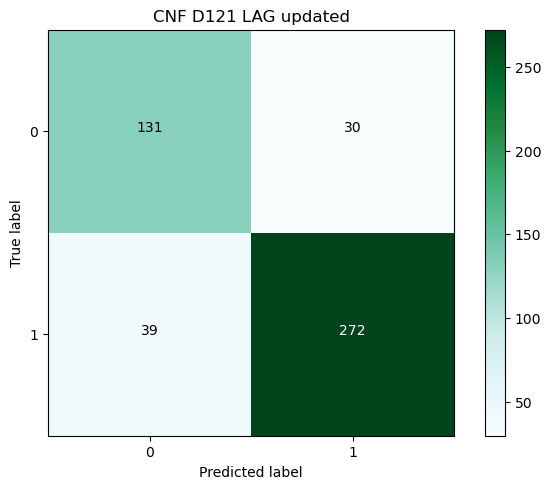

In [23]:
classes = [0, 1]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.BuGn)
plt.title("CNF D121 LAG updated")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

### DenseNet-169

In [24]:
#DenseNet169
import time
epochs =50
batch_size = 10

start = time.time()
history_2 = model2.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=epochs, batch_size =batch_size,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
end = time.time()
print("Execution Time : ", (end - start))

Epoch 1/50
342/342 [==============================] - 94s 247ms/step - loss: 0.5285 - accuracy: 0.7368 - mse: 0.1762 - val_loss: 0.8840 - val_accuracy: 0.3580 - val_mse: 0.3396
Epoch 2/50
342/342 [==============================] - 81s 237ms/step - loss: 0.4357 - accuracy: 0.8023 - mse: 0.1393 - val_loss: 0.5608 - val_accuracy: 0.7243 - val_mse: 0.1873
Epoch 3/50
342/342 [==============================] - 81s 237ms/step - loss: 0.3990 - accuracy: 0.8269 - mse: 0.1256 - val_loss: 0.4193 - val_accuracy: 0.8220 - val_mse: 0.1287
Epoch 4/50
342/342 [==============================] - 81s 237ms/step - loss: 0.3609 - accuracy: 0.8509 - mse: 0.1113 - val_loss: 0.3937 - val_accuracy: 0.8323 - val_mse: 0.1204
Epoch 5/50
342/342 [==============================] - 81s 237ms/step - loss: 0.3367 - accuracy: 0.8623 - mse: 0.1032 - val_loss: 0.3964 - val_accuracy: 0.8374 - val_mse: 0.1214
Epoch 6/50
342/342 [==============================] - 81s 237ms/step - loss: 0.3176 - accuracy: 0.8722 - mse: 0.095

In [25]:

model2.save('SavedModels/LAG updated/D169.h5')

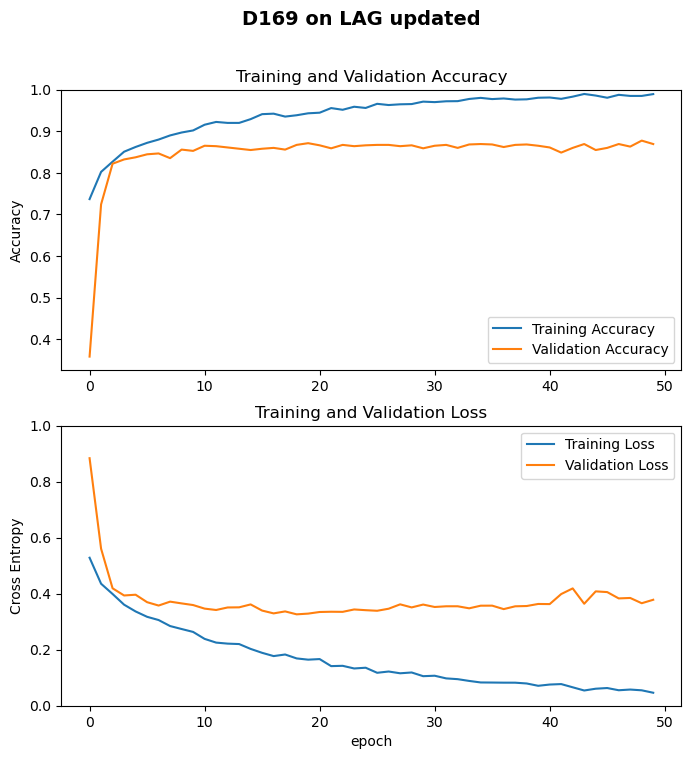

In [26]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.suptitle('D169 on LAG updated', fontsize=14, fontweight='bold')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [27]:
start=time.time()
test_output_2= model2.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
end=time.time()
print(model2.metrics_names)
print(test_output_2)
print("testing time : "+ str(end-start))

47/47 [==============================] - 6s 137ms/step - loss: 0.3973 - accuracy: 0.8835 - mse: 0.1001
['loss', 'accuracy', 'mse']
[0.3972676396369934, 0.883474588394165, 0.10008610039949417]
testing time : 6.556252479553223


In [28]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


#Y_pred = model1.predict_generator(validation_generator, 171 // batch_size+1)
Y_pred=model2.predict(test_generator,test_generator.samples//batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
conf=confusion_matrix(test_generator.classes, y_pred)
print(conf)
print('Classification Report')
target_names = ['Gluacoma', 'Normal']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

48/48 [==============================] - 8s 132ms/step
Confusion Matrix
[[133  28]
 [ 27 284]]
Classification Report
              precision    recall  f1-score   support

    Gluacoma       0.83      0.83      0.83       161
      Normal       0.91      0.91      0.91       311

    accuracy                           0.88       472
   macro avg       0.87      0.87      0.87       472
weighted avg       0.88      0.88      0.88       472



Text(0.5, 23.52222222222222, 'Predicted label')

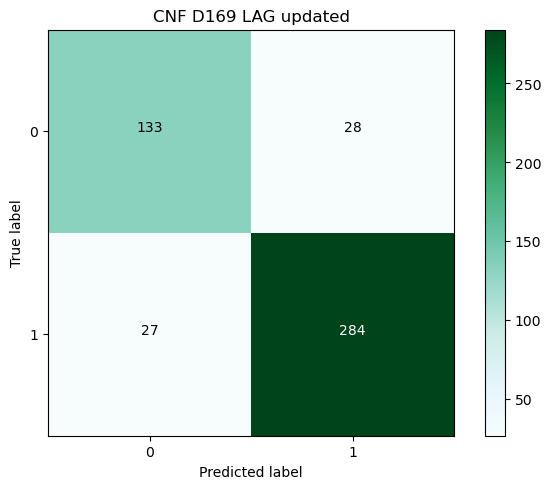

In [29]:
classes = [0, 1]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.BuGn)
plt.title("CNF D169 LAG updated")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

### 3. VGG-19

In [17]:
#Vgg-19
import time
epochs =50
batch_size = 10

start = time.time()
history_3 = model3.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=epochs, batch_size =batch_size,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
end = time.time()
print("Execution Time : ", (end - start))

Epoch 1/50
342/342 [==============================] - 112s 302ms/step - loss: 0.4992 - accuracy: 0.7626 - mse: 0.1632 - val_loss: 0.5158 - val_accuracy: 0.7737 - val_mse: 0.1676
Epoch 2/50
342/342 [==============================] - 158s 462ms/step - loss: 0.4047 - accuracy: 0.8278 - mse: 0.1268 - val_loss: 0.3360 - val_accuracy: 0.8560 - val_mse: 0.1020
Epoch 3/50
342/342 [==============================] - 178s 520ms/step - loss: 0.3640 - accuracy: 0.8518 - mse: 0.1116 - val_loss: 0.3169 - val_accuracy: 0.8714 - val_mse: 0.0953
Epoch 4/50
342/342 [==============================] - 178s 522ms/step - loss: 0.3415 - accuracy: 0.8629 - mse: 0.1035 - val_loss: 0.3474 - val_accuracy: 0.8549 - val_mse: 0.1067
Epoch 5/50
342/342 [==============================] - 181s 528ms/step - loss: 0.3119 - accuracy: 0.8749 - mse: 0.0935 - val_loss: 0.2867 - val_accuracy: 0.8765 - val_mse: 0.0872
Epoch 6/50
342/342 [==============================] - 177s 517ms/step - loss: 0.2869 - accuracy: 0.8880 - mse:

Epoch 47/50
342/342 [==============================] - 173s 507ms/step - loss: 0.0628 - accuracy: 0.9819 - mse: 0.0153 - val_loss: 0.3906 - val_accuracy: 0.8570 - val_mse: 0.1092
Epoch 48/50
342/342 [==============================] - 174s 510ms/step - loss: 0.0474 - accuracy: 0.9886 - mse: 0.0105 - val_loss: 0.2273 - val_accuracy: 0.9115 - val_mse: 0.0647
Epoch 49/50
342/342 [==============================] - 174s 508ms/step - loss: 0.0569 - accuracy: 0.9851 - mse: 0.0139 - val_loss: 0.2532 - val_accuracy: 0.9095 - val_mse: 0.0693
Epoch 50/50
342/342 [==============================] - 174s 509ms/step - loss: 0.0559 - accuracy: 0.9816 - mse: 0.0139 - val_loss: 0.3253 - val_accuracy: 0.8765 - val_mse: 0.0901
Execution Time :  8615.151079893112


In [18]:
model3.save('SavedModels/LAG updated/VGG19.h5')

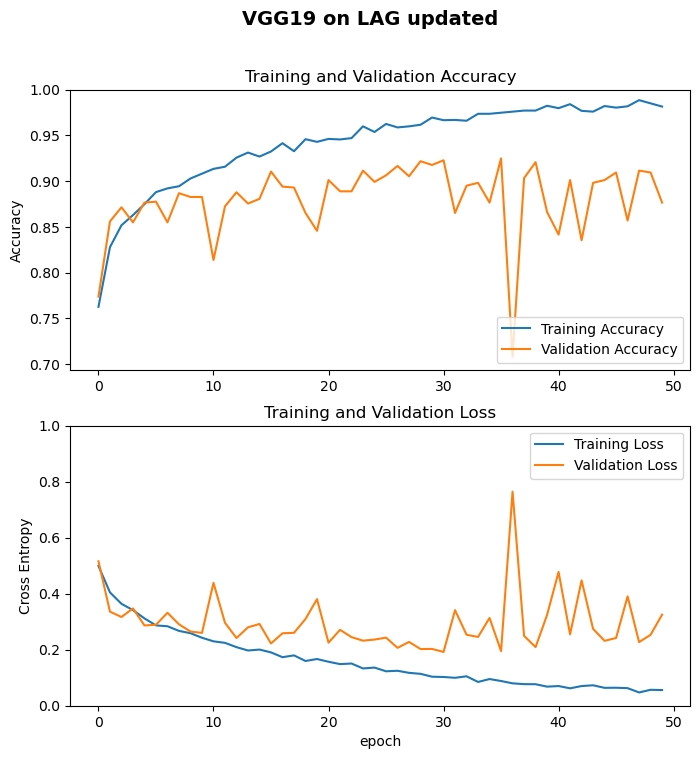

In [19]:
acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']

loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.suptitle('VGG19 on LAG updated', fontsize=14, fontweight='bold')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [20]:
start=time.time()
test_output_3= model3.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
end=time.time()
print(model3.metrics_names)
print(test_output_3)
print("testing time : "+ str(end-start))

47/47 [==============================] - 14s 291ms/step - loss: 0.3021 - accuracy: 0.9004 - mse: 0.0808
['loss', 'accuracy', 'mse']
[0.3020710051059723, 0.9004237055778503, 0.08083441853523254]
testing time : 13.877059936523438


In [21]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


#Y_pred = model1.predict_generator(validation_generator, 171 // batch_size+1)
Y_pred=model3.predict(test_generator,test_generator.samples//batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
conf=confusion_matrix(test_generator.classes, y_pred)
print(conf)
print('Classification Report')
target_names = ['Gluacoma', 'Normal']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

48/48 [==============================] - 14s 287ms/step
Confusion Matrix
[[122  39]
 [  8 303]]
Classification Report
              precision    recall  f1-score   support

    Gluacoma       0.94      0.76      0.84       161
      Normal       0.89      0.97      0.93       311

    accuracy                           0.90       472
   macro avg       0.91      0.87      0.88       472
weighted avg       0.90      0.90      0.90       472



Text(0.5, 23.52222222222222, 'Predicted label')

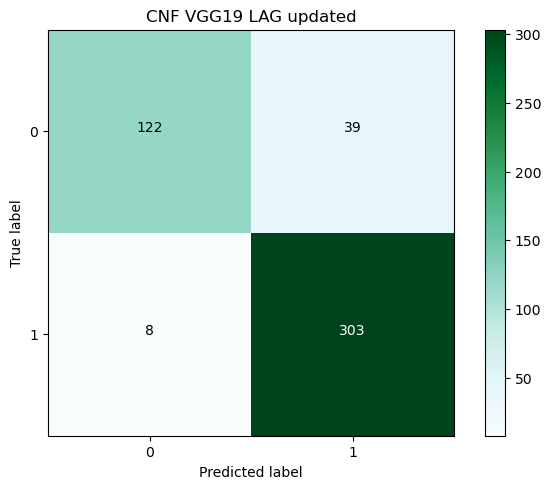

In [22]:
import itertools
classes = [0, 1]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.BuGn)
plt.title("CNF VGG19 LAG updated")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

### 4. MobileNet V2

In [24]:
#MobileNet 
import time
epochs =50
batch_size = 10

start = time.time()
history_4 = model4.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=epochs, batch_size =batch_size,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
end = time.time()
print("Execution Time : ", (end - start))

Epoch 1/50
342/342 [==============================] - 46s 105ms/step - loss: 0.4957 - accuracy: 0.7626 - mse: 0.1633 - val_loss: 0.3943 - val_accuracy: 0.8313 - val_mse: 0.1212
Epoch 2/50
342/342 [==============================] - 34s 99ms/step - loss: 0.3706 - accuracy: 0.8459 - mse: 0.1141 - val_loss: 0.3623 - val_accuracy: 0.8508 - val_mse: 0.1098
Epoch 3/50
342/342 [==============================] - 34s 99ms/step - loss: 0.3067 - accuracy: 0.8825 - mse: 0.0919 - val_loss: 0.3317 - val_accuracy: 0.8611 - val_mse: 0.1002
Epoch 4/50
342/342 [==============================] - 34s 99ms/step - loss: 0.2824 - accuracy: 0.8904 - mse: 0.0838 - val_loss: 0.3105 - val_accuracy: 0.8663 - val_mse: 0.0938
Epoch 5/50
342/342 [==============================] - 34s 99ms/step - loss: 0.2447 - accuracy: 0.9067 - mse: 0.0706 - val_loss: 0.2963 - val_accuracy: 0.8755 - val_mse: 0.0898
Epoch 6/50
342/342 [==============================] - 34s 98ms/step - loss: 0.2145 - accuracy: 0.9219 - mse: 0.0605 - v

342/342 [==============================] - 33s 98ms/step - loss: 0.0267 - accuracy: 0.9921 - mse: 0.0060 - val_loss: 0.3244 - val_accuracy: 0.9064 - val_mse: 0.0787
Epoch 48/50
342/342 [==============================] - 34s 98ms/step - loss: 0.0208 - accuracy: 0.9968 - mse: 0.0038 - val_loss: 0.3378 - val_accuracy: 0.9023 - val_mse: 0.0783
Epoch 49/50
342/342 [==============================] - 34s 98ms/step - loss: 0.0205 - accuracy: 0.9959 - mse: 0.0039 - val_loss: 0.3394 - val_accuracy: 0.9002 - val_mse: 0.0810
Epoch 50/50
342/342 [==============================] - 34s 98ms/step - loss: 0.0222 - accuracy: 0.9953 - mse: 0.0046 - val_loss: 0.3413 - val_accuracy: 0.8951 - val_mse: 0.0816
Execution Time :  1698.9989869594574


In [26]:
model4.save('SavedModels/LAG Updated/MobileNet.h5')

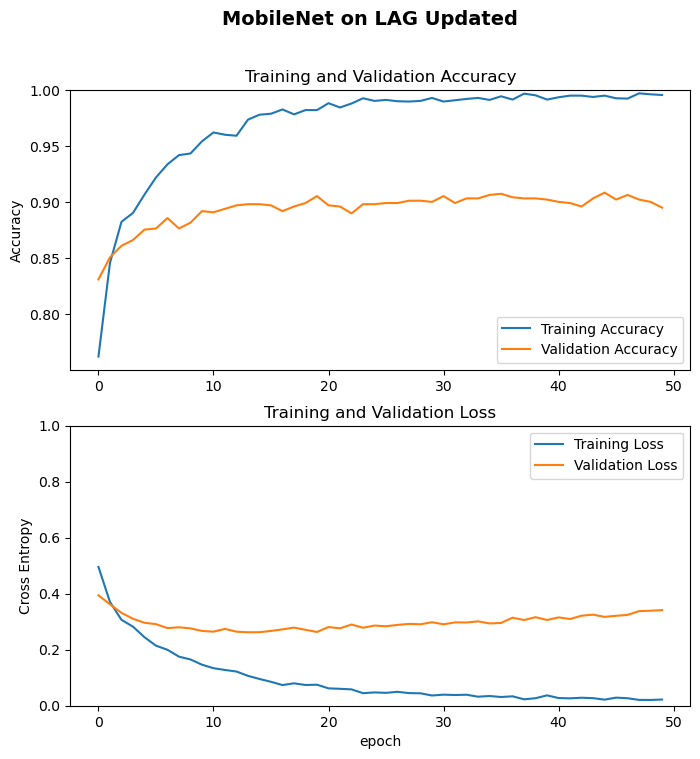

In [27]:
acc = history_4.history['accuracy']
val_acc = history_4.history['val_accuracy']

loss = history_4.history['loss']
val_loss = history_4.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.suptitle('MobileNet on LAG Updated', fontsize=14, fontweight='bold')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [28]:
start=time.time()
test_output_4= model4.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
end=time.time()
print(model4.metrics_names)
print(test_output_4)
print("testing time : "+ str(end-start))

47/47 [==============================] - 2s 48ms/step - loss: 0.3947 - accuracy: 0.8898 - mse: 0.0884
['loss', 'accuracy', 'mse']
[0.3947455883026123, 0.8898305296897888, 0.08843765407800674]
testing time : 2.3764398097991943


In [29]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


#Y_pred = model1.predict_generator(validation_generator, 171 // batch_size+1)
Y_pred=model4.predict(test_generator,test_generator.samples//batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
conf=confusion_matrix(test_generator.classes, y_pred)
print(conf)
print('Classification Report')
target_names = ['Gluacoma', 'Normal']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

48/48 [==============================] - 3s 38ms/step
Confusion Matrix
[[138  23]
 [ 29 282]]
Classification Report
              precision    recall  f1-score   support

    Gluacoma       0.83      0.86      0.84       161
      Normal       0.92      0.91      0.92       311

    accuracy                           0.89       472
   macro avg       0.88      0.88      0.88       472
weighted avg       0.89      0.89      0.89       472



Text(0.5, 23.52222222222222, 'Predicted label')

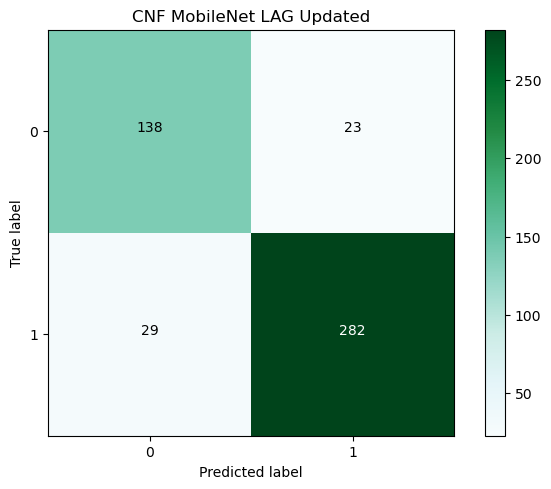

In [31]:
import itertools
classes = [0, 1]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.BuGn)
plt.title("CNF MobileNet LAG Updated")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

## ResNet50

In [32]:
#ResNet 50
import time
epochs =50
batch_size = 10

start = time.time()
history_5 = model5.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=epochs, batch_size =batch_size,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
end = time.time()
print("Execution Time : ", (end - start))

Epoch 1/50
342/342 [==============================] - 67s 183ms/step - loss: 0.6409 - accuracy: 0.6746 - mse: 0.2242 - val_loss: 0.7614 - val_accuracy: 0.6420 - val_mse: 0.2672
Epoch 2/50
342/342 [==============================] - 60s 177ms/step - loss: 0.5698 - accuracy: 0.7515 - mse: 0.1911 - val_loss: 0.5573 - val_accuracy: 0.7778 - val_mse: 0.1850
Epoch 3/50
342/342 [==============================] - 60s 177ms/step - loss: 0.5198 - accuracy: 0.7702 - mse: 0.1702 - val_loss: 1.5694 - val_accuracy: 0.3601 - val_mse: 0.5054
Epoch 4/50
342/342 [==============================] - 61s 177ms/step - loss: 0.4947 - accuracy: 0.7798 - mse: 0.1609 - val_loss: 0.7175 - val_accuracy: 0.6481 - val_mse: 0.2493
Epoch 5/50
342/342 [==============================] - 61s 177ms/step - loss: 0.4681 - accuracy: 0.7971 - mse: 0.1501 - val_loss: 0.9066 - val_accuracy: 0.4733 - val_mse: 0.3250
Epoch 6/50
342/342 [==============================] - 61s 177ms/step - loss: 0.4394 - accuracy: 0.8070 - mse: 0.139

342/342 [==============================] - 61s 177ms/step - loss: 0.2841 - accuracy: 0.8719 - mse: 0.0877 - val_loss: 24.0013 - val_accuracy: 0.3580 - val_mse: 0.6420
Epoch 48/50
342/342 [==============================] - 61s 177ms/step - loss: 0.2702 - accuracy: 0.8842 - mse: 0.0826 - val_loss: 3.3756 - val_accuracy: 0.6420 - val_mse: 0.3572
Epoch 49/50
342/342 [==============================] - 61s 177ms/step - loss: 0.2906 - accuracy: 0.8737 - mse: 0.0896 - val_loss: 6.8320 - val_accuracy: 0.6420 - val_mse: 0.3580
Epoch 50/50
342/342 [==============================] - 61s 177ms/step - loss: 0.2809 - accuracy: 0.8804 - mse: 0.0865 - val_loss: 0.5518 - val_accuracy: 0.7665 - val_mse: 0.1712
Execution Time :  3041.821650505066


In [33]:
model5.save('SavedModels/LAG updated/ResNet.h5')

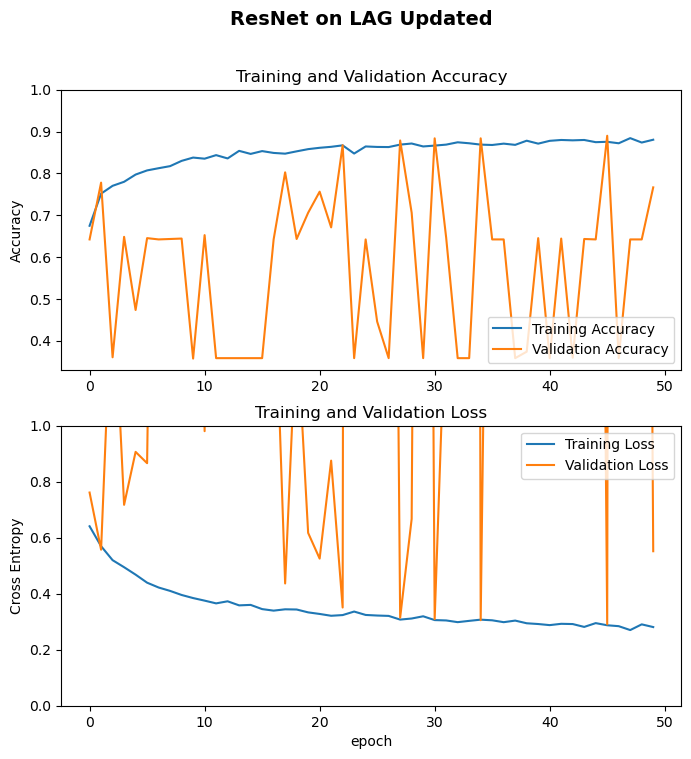

In [34]:
acc = history_5.history['accuracy']
val_acc = history_5.history['val_accuracy']

loss = history_5.history['loss']
val_loss = history_5.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.suptitle('ResNet on LAG Updated', fontsize=14, fontweight='bold')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [35]:
start=time.time()
test_output_5= model5.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
end=time.time()
print(model5.metrics_names)
print(test_output_5)
print("testing time : "+ str(end-start))

47/47 [==============================] - 5s 97ms/step - loss: 0.4708 - accuracy: 0.7860 - mse: 0.1477
['loss', 'accuracy', 'mse']
[0.470823734998703, 0.7860169410705566, 0.14772234857082367]
testing time : 4.704058408737183


In [36]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


#Y_pred = model1.predict_generator(validation_generator, 171 // batch_size+1)
Y_pred=model5.predict(test_generator,test_generator.samples//batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
conf=confusion_matrix(test_generator.classes, y_pred)
print(conf)
print('Classification Report')
target_names = ['Gluacoma', 'Normal']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

48/48 [==============================] - 5s 91ms/step
Confusion Matrix
[[ 61 100]
 [  1 310]]
Classification Report
              precision    recall  f1-score   support

    Gluacoma       0.98      0.38      0.55       161
      Normal       0.76      1.00      0.86       311

    accuracy                           0.79       472
   macro avg       0.87      0.69      0.70       472
weighted avg       0.83      0.79      0.75       472



Text(0.5, 23.52222222222222, 'Predicted label')

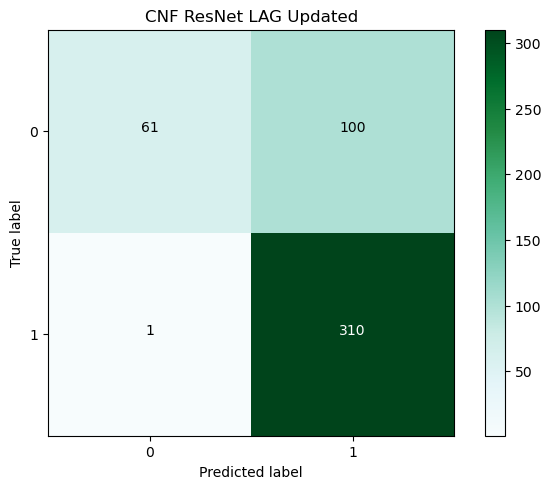

In [37]:
classes = [0, 1]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.BuGn)
plt.title("CNF ResNet LAG Updated")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

### 6. Inception V3

In [38]:
#Inception V3
import time
epochs =50
batch_size = 10

start = time.time()
history_6 = model6.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=epochs, batch_size =batch_size,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
end = time.time()
print("Execution Time : ", (end - start))

Epoch 1/50
342/342 [==============================] - 49s 125ms/step - loss: 0.5427 - accuracy: 0.7325 - mse: 0.1822 - val_loss: 0.4450 - val_accuracy: 0.8066 - val_mse: 0.1415
Epoch 2/50
342/342 [==============================] - 48s 139ms/step - loss: 0.4109 - accuracy: 0.8199 - mse: 0.1302 - val_loss: 0.4193 - val_accuracy: 0.8117 - val_mse: 0.1322
Epoch 3/50
342/342 [==============================] - 51s 149ms/step - loss: 0.3421 - accuracy: 0.8675 - mse: 0.1034 - val_loss: 0.4059 - val_accuracy: 0.8076 - val_mse: 0.1285
Epoch 4/50
342/342 [==============================] - 53s 154ms/step - loss: 0.2966 - accuracy: 0.8915 - mse: 0.0874 - val_loss: 0.3996 - val_accuracy: 0.8230 - val_mse: 0.1256
Epoch 5/50
342/342 [==============================] - 56s 163ms/step - loss: 0.2645 - accuracy: 0.9035 - mse: 0.0759 - val_loss: 0.4101 - val_accuracy: 0.8138 - val_mse: 0.1291
Epoch 6/50
342/342 [==============================] - 66s 194ms/step - loss: 0.2291 - accuracy: 0.9216 - mse: 0.063

342/342 [==============================] - 40s 118ms/step - loss: 0.0199 - accuracy: 0.9974 - mse: 0.0035 - val_loss: 0.4821 - val_accuracy: 0.8385 - val_mse: 0.1258
Epoch 48/50
342/342 [==============================] - 40s 118ms/step - loss: 0.0141 - accuracy: 0.9988 - mse: 0.0019 - val_loss: 0.4955 - val_accuracy: 0.8405 - val_mse: 0.1256
Epoch 49/50
342/342 [==============================] - 40s 118ms/step - loss: 0.0175 - accuracy: 0.9977 - mse: 0.0029 - val_loss: 0.5120 - val_accuracy: 0.8323 - val_mse: 0.1310
Epoch 50/50
342/342 [==============================] - 40s 118ms/step - loss: 0.0186 - accuracy: 0.9962 - mse: 0.0035 - val_loss: 0.5016 - val_accuracy: 0.8405 - val_mse: 0.1278
Execution Time :  2758.821498155594


In [39]:
model6.save('SavedModels/LAG updated/Inception.h5')

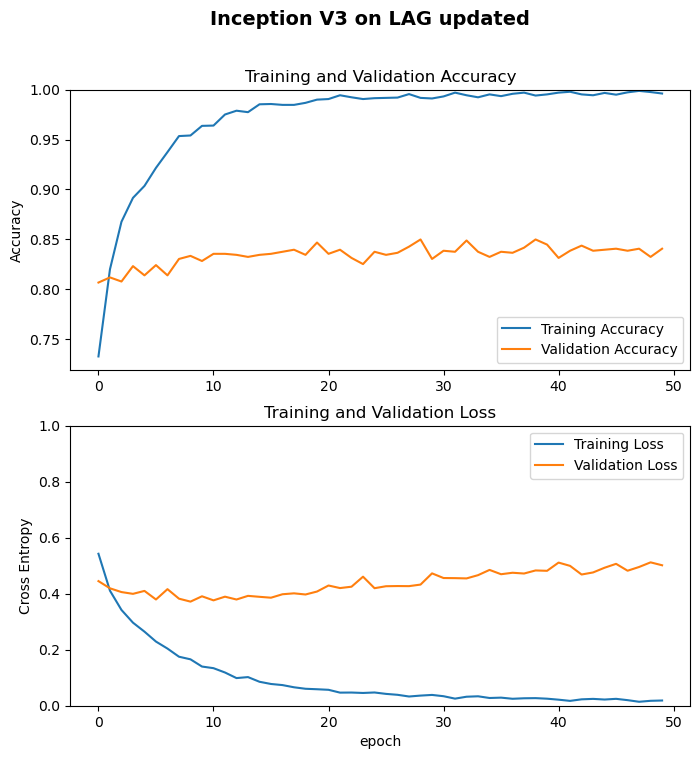

In [40]:
acc = history_6.history['accuracy']
val_acc = history_6.history['val_accuracy']

loss = history_6.history['loss']
val_loss = history_6.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.suptitle("Inception V3 on LAG updated", fontsize=14, fontweight='bold')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [41]:
start=time.time()
test_output_6= model6.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
end=time.time()
print(model6.metrics_names)
print(test_output_6)
print("testing time : "+ str(end-start))

47/47 [==============================] - 3s 62ms/step - loss: 0.5367 - accuracy: 0.8347 - mse: 0.1354
['loss', 'accuracy', 'mse']
[0.53665691614151, 0.8347457647323608, 0.1353992074728012]
testing time : 3.0513877868652344


In [42]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


#Y_pred = model1.predict_generator(validation_generator, 171 // batch_size+1)
Y_pred=model6.predict(test_generator,test_generator.samples//batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
conf=confusion_matrix(test_generator.classes, y_pred)
print(conf)
print('Classification Report')
target_names = ['Gluacoma', 'Normal']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

48/48 [==============================] - 4s 57ms/step
Confusion Matrix
[[125  36]
 [ 42 269]]
Classification Report
              precision    recall  f1-score   support

    Gluacoma       0.75      0.78      0.76       161
      Normal       0.88      0.86      0.87       311

    accuracy                           0.83       472
   macro avg       0.82      0.82      0.82       472
weighted avg       0.84      0.83      0.84       472



Text(0.5, 23.52222222222222, 'Predicted label')

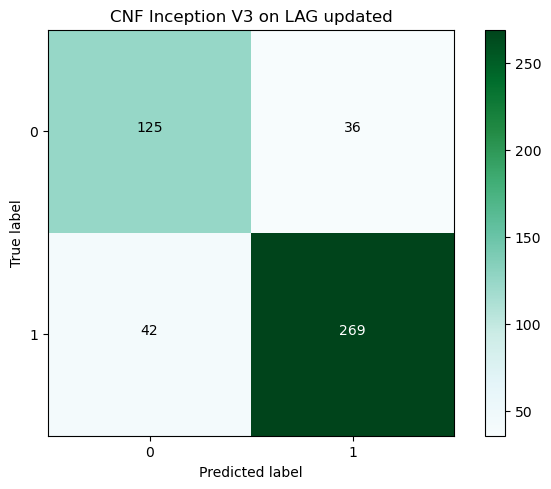

In [43]:
classes = [0, 1]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.BuGn)
plt.title("CNF Inception V3 on LAG updated")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')